In [2]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

import os

import matplotlib.pyplot as plt
from pylab import rcParams; rcParams['font.family'] = ['DejaVu Sans']
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

import configparser
conf = configparser.RawConfigParser(); conf.read(os.path.join(os.path.expanduser('~'), 'conf.conf'))

import requests
from requests.auth import HTTPProxyAuth

import jmespath
import json

In [3]:
df = pd.read_json('./declarations.json')
print(df.shape)
df.head(1)

(203694, 8)


,bonds,incomes,main,real_estates,savings,spendings,stocks,vehicles
0,[],"[{'size': 2126487.0, 'relative': None, 'commen...","{'person': {'id': 8, 'name': 'Зюганов Геннадий...","[{'name': '', 'square': 167.4, 'country': 'Рос...","[2 652 390,0 руб. (ВТБ 24 (ЗАО)), 474 061,0 ру...",[],[],[]


In [4]:
def flatten(d, parent_key='', sep='_'):
    import collections
    
    items = []
    for k, v in d.items():
        if v is not None:
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.MutableMapping):
                items.extend(flatten(v, new_key, sep=sep).items())
            elif isinstance(v, list):
                items.append((new_key, v[0] if isinstance(v[0], dict) else '|'.join(sorted(v))))
            else:
                items.append((new_key, v))
    return dict(items)

## Обрабатываем доходы

In [5]:
def relative_grouper(x):
    relative_grouper = {
        'None': 'Доход',
        2: 'Супруг(а)',
        3: 'Ребенок',
        4: 'Ребенок',
        5: 'Иное',
        6: 'Ребенок',
    }
    
    idx = 'None' if x.get('relative') is None else x.get('relative', {}).get('id')
    
    return relative_grouper.get(idx, )


def preproc_income(income_list):
    from itertools import groupby
    income_dict = {}
    for k, v in groupby(income_list, key=relative_grouper):
        income_dict[f'{k}'] = 0
        income_dict[f'{k}_cmnt'] = []
        income_dict[f'{k}_cnt'] = 0
        for d in v:
            income_dict[f'{k}'] += d['size'] / 12
            income_dict[f'{k}_cmnt'].append(d['comment'])
            income_dict[f'{k}_cnt'] += 1
        income_dict[f'{k}_cmnt'] = ' '.join(income_dict[f'{k}_cmnt']).strip()
    return income_dict

# Собираем датасет

In [6]:
import collections 
    
data_list = []

for idx, row in tqdm(df.iloc[:].iterrows()):
    
    object_dict_list = []
    
    ####### incomes
    object_dict_list.append(preproc_income(row['incomes']))
    
    ####### main
    main = flatten(row['main'])
    object_dict_list.append(main)
    
    ###### real_estates
    object_dict_list.append({'real_estates': row['real_estates']})
    
    ###### vehicles
    ####### incomes
    object_dict_list.append({'vehicles': row['vehicles']})
        
    result = dict(collections.ChainMap(*[{} if dct is None else dct for dct in object_dict_list]))
    
    data_list.append(result)

In [7]:
p_df = pd.DataFrame(data_list)
print(p_df.shape)
# Удалим дубликаты по ключу 'office_id', 'person_id', 'year'
p_df = p_df\
    .drop_duplicates(subset=['office_id', 'person_id', 'year'])\
    .reset_index(drop=True)
print(p_df.shape)
p_df.head(1)

(203694, 32)
(203341, 32)


,document_type_id,document_type_name,office_id,office_name,office_region_id,office_region_name,office_type_id,office_type_name,office_url,party_id,party_name,person_family_name,person_gender,person_given_name,person_id,person_name,person_patronymic_name,real_estates,vehicles,year,Доход,Доход_cmnt,Доход_cnt,Иное,Иное_cmnt,Иное_cnt,Ребенок,Ребенок_cmnt,Ребенок_cnt,Супруг(а),Супруг(а)_cmnt,Супруг(а)_cnt
0,2,Предвыборная декларация,14,Государственная Дума,NaN,NaN,7,"Федеральный, без региональной структуры",http://www.duma.gov.ru/,6.0,КПРФ,Зюганов,M,Геннадий,8,Зюганов Геннадий Андреевич,Андреевич,"[{'name': '', 'square': 167.4, 'country': 'Рос...",[],2010,177207.25,"пенсия, Аппарат Государственной Думы Федераль...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
p_df.loc[:, 'real_estates_cnt'] = p_df['real_estates'].str.len()
p_df.loc[:, 'vehicles_cnt'] = p_df['vehicles'].str.len()

# Модель

In [28]:
columns_to_drop = [
    'document_type_id', 'office_region_id', 'office_type_id', 'office_url', 'party_id',
    'person_given_name', 'person_patronymic_name', 'real_estates', 'vehicles', 
    'Доход_cmnt', 'Доход_cnt',
    'Иное_cmnt', 'Ребенок_cmnt', 'Супруг(а)_cmnt'
]

Xy = p_df\
    .set_index(['office_id', 'person_id', 'person_name'])\
    .drop(columns_to_drop, axis=1)\
    .dropna(subset=['Доход'])
print(f'Размер датасета: {Xy.shape}')

Xy = Xy[
    (Xy['Доход'] < np.percentile(Xy['Доход'], 95))
    & (Xy['Доход'] > np.percentile(Xy['Доход'], 5))  
]
print(f'Размер датасета: {Xy.shape}')

X_tr = Xy[Xy['year']!=2018].drop(['year', 'Доход'], axis=1)
y_tr = Xy[Xy['year']!=2018]['Доход']
print(f'Размер трейна: {X_tr.shape}')

X_val = Xy[Xy['year']==2018].drop(['year', 'Доход'], axis=1)
y_val = Xy[Xy['year']==2018]['Доход']
print(f'Размер теста: {X_val.shape}')

X_tr.head(2)

Размер датасета: (202629, 17)
Размер датасета: (182365, 17)
Размер трейна: (179229, 15)
Размер теста: (3136, 15)


document_type_name  \
office_id person_id person_name                                           
14        8         Зюганов Геннадий Андреевич  Предвыборная декларация   
          10        Андреев Андрей Анатольевич  Предвыборная декларация   

                                                         office_name  \
office_id person_id person_name                                        
14        8         Зюганов Геннадий Андреевич  Государственная Дума   
          10        Андреев Андрей Анатольевич  Государственная Дума   

                                               office_region_name  \
office_id person_id person_name                                     
14        8         Зюганов Геннадий Андреевич                NaN   
          10        Андреев Андрей Анатольевич                NaN   

                                                                       office_type_name  \
office_id person_id person_name                                                           
14        8         Зюганов Геннадий Андреевич  Федеральный, без региональной структуры   
          10        Андреев Андрей Анатольевич  Федеральный, без региональной структуры   

                                               party_name person_family_name  \
office_id person_id person_name                                                
14        8         Зюганов Геннадий Андреевич       КПРФ            Зюганов   
          10        Андреев Андрей Анатольевич       КПРФ            Андреев   

                                               person_gender  Иное  Иное_cnt  \
office_id person_id person_name                                                
14        8         Зюганов Геннадий Андреевич             M   NaN       NaN   
          10        Андреев Андрей Анатольевич             M   NaN       NaN   

                                                Ребенок  Ребенок_cnt  \
office_id person_id person_name                                        
14        8         Зюганов Геннадий Андреевич      NaN          NaN   
          10        Андреев Андрей Анатольевич      NaN          NaN   

                                                Супруг(а)  Супруг(а)_cnt  \
office_id person_id person_name                                            
14        8         Зюганов Геннадий Андреевич        NaN            NaN   
          10        Андреев Андрей Анатольевич        NaN            NaN   

                                                real_estates_cnt  vehicles_cnt  
office_id person_id person_name                                                 
14        8         Зюганов Геннадий Андреевич                 1             0  
          10        Андреев Андрей Анатольевич                 0             1

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor


class CatboostFillNACategory(BaseEstimator, TransformerMixin):

    def __init__(self, cat_features, fill_value='NAN_category'):
        self.cat_features=cat_features
        self.fill_value=fill_value
                
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        res = X.copy()
        res[self.cat_features] = res[self.cat_features].fillna(self.fill_value).astype(str)
        return res

cat_features_list = [
    'document_type_name', 'office_name', 'office_region_name',
    'office_type_name', 'party_name', 'person_family_name', 
    'person_gender',
]

cbfnac = CatboostFillNACategory(cat_features=cat_features_list)
cb_classifier = CatBoostRegressor(
    eval_metric='MAE', verbose=100, random_state=42,
    task_type='GPU', devices='0',
    grow_policy='SymmetricTree', #n_estimators=1200, depth=7
)

pipeline = Pipeline([("transformer", cbfnac), ("estimator", cb_classifier)])

In [30]:
pipeline.fit(
    X=X_tr, 
    y=y_tr, 
    estimator__cat_features=cat_features_list, 
)

0:	learn: 128258.8438255	total: 25.7ms	remaining: 25.6s
100:	learn: 44707.7877799	total: 1.93s	remaining: 17.2s
200:	learn: 44811.1653360	total: 3.93s	remaining: 15.6s
300:	learn: 44402.7714265	total: 5.87s	remaining: 13.6s
400:	learn: 44134.5062685	total: 7.69s	remaining: 11.5s
500:	learn: 43946.1281824	total: 9.65s	remaining: 9.62s
600:	learn: 43794.7926731	total: 11.6s	remaining: 7.67s
700:	learn: 43670.0157229	total: 13.5s	remaining: 5.74s
800:	learn: 43550.8035865	total: 15.3s	remaining: 3.79s
900:	learn: 43449.4856971	total: 17.1s	remaining: 1.88s
999:	learn: 43368.9073085	total: 18.9s	remaining: 0us


Pipeline(memory=None,
     steps=[('transformer', CatboostFillNACategory(cat_features=['document_type_name', 'office_name', 'office_region_name', 'office_type_name', 'party_name', 'person_family_name', 'person_gender'],
            fill_value='NAN_category')), ('estimator', <catboost.core.CatBoostRegressor object at 0x7f4df0f53898>)])

In [56]:
scored = Xy[Xy['year']==2018][['Доход']]
scored.loc[:, 'Доход'] = scored['Доход'].astype(int)
scored.loc[:, 'Предсказание'] = pipeline.predict(X_val).astype(int)
scored.head()

/opt/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


,,,Доход,Предсказание
office_id,person_id,person_name,,
124,558,Евкуров Юнус-Бек Баматгиреевич,218450,231194
126,562,Темрезов Рашид Бориспиевич,128962,102746
123,203,Васильев Владимир Абдуалиевич,411846,237663
1397,21002,Кропоткин Андрей Михайлович,164985,120723
453,132632,Чеботарев Сергей Викторович,508807,319647


In [59]:
import dill

with open('./pipeline.dill', 'wb') as f:
    dill.dump(pipeline, f)
    
with open('./scored.dill', 'wb') as f:
    dill.dump(scored, f)

In [31]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

print(mean_absolute_error(y_val, pipeline.predict(X_val)))
print(median_absolute_error(y_val, pipeline.predict(X_val)))

64035.540176074326
43555.334835103575


In [38]:
y_val.mean()

199008.76988786156

In [39]:
y_val.median()

146690.25916666666

In [37]:
importances = pd.DataFrame(data={
    'features': cb_classifier.feature_names_,
    'fscore': cb_classifier.feature_importances_
}).sort_values('fscore', ascending=False)

importances.head(20)

,features,fscore
1,office_name,32.313349
2,office_region_name,15.612044
3,office_type_name,12.582778
13,real_estates_cnt,8.990276
4,party_name,7.516127
11,Супруг(а),6.935550
6,person_gender,6.791058
5,person_family_name,3.781617
0,document_type_name,2.283226
14,vehicles_cnt,1.997325


/home/mvshevc5/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


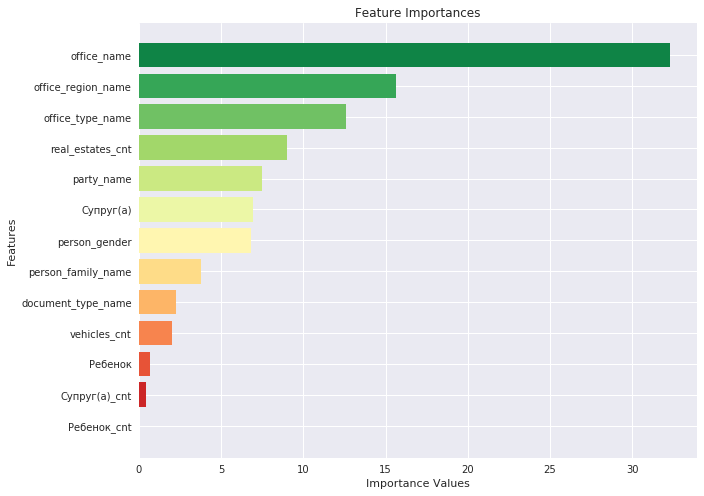

1            office_name
2     office_region_name
3       office_type_name
13      real_estates_cnt
4             party_name
11             Супруг(а)
6          person_gender
5     person_family_name
0     document_type_name
Name: features, dtype: object

In [71]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as image


def plot_feature_importances(names, coefs, color=2, n=None):
    importances = pd.DataFrame(
        data={
            'features': names,
            'fscore': coefs
        }
    )

    importances = importances[importances['fscore']!=0]
    importances = importances.reindex(importances.fscore.abs().sort_values(ascending=True).index)

    f_names = importances['features']
    f_values = importances['fscore']

    st_idx = 0; end_idx = len(f_names);

    fig = plt.figure(figsize=(10, 8))
    plt.barh(
        np.arange(len(f_names)), f_values,
        color=[cm.RdYlGn(i*color) for i in range(len(f_names))])
    fig.axes[0].set_yticklabels(f_names[st_idx : end_idx])
    fig.axes[0].set_yticks(np.arange(len(f_names[st_idx : end_idx])))
    fig.axes[0].set_xlabel('Importance Values')
    fig.axes[0].set_ylabel('Features')
    fig.axes[0].set_title('Feature Importances')

    plt.show()

    if n is not None:
        return f_names[:-n:-1]


plot_feature_importances(X_tr.columns, cb_classifier.feature_importances_,  color=20, n=10)